In [1]:
import mysql.connector as sql
import pandas as pd
import datetime as dt
import numpy as np
from sorted_months_weekdays import *
from sort_dataframeby_monthorweek import *
import matplotlib.pyplot as plt
import math
import requests
import json
from pandas.io.json import json_normalize
import matplotlib.dates as mdates
from datetime import date, timedelta

In [2]:
url = 'https://api.collection.cooperhewitt.org/rest/?method=cooperhewitt.exhibitions.getList&access_token=729cca8ffeb40cd2e725f5301e034134'
resp = requests.request('GET', url)
exhibition = json.loads(resp.text)
exhibition = pd.json_normalize(exhibition['exhibitions'])
exhibition['date_start'] = pd.to_datetime(exhibition['date_start'])
exhibition['date_end'].replace('0000-00-00', '2020-12-30', inplace=True)
exhibition['date_end'] = pd.to_datetime(exhibition['date_end'])
##filtering by the pens dates
exhibition= exhibition[exhibition['date_start'] >= '2014-01-01']

db_connection = sql.connect(host='localhost', database='collection_users', user='pandas', password='password')

sbBundles = pd.read_sql('SELECT * FROM UsersShoeboxBundles', con=db_connection)
sbBundles['created'] = pd.to_datetime(sbBundles['created'], unit='s').dt.tz_localize('utc').dt.tz_convert('US/Eastern')
sbBundles['lastmodified'] = pd.to_datetime(sbBundles['lastmodified'], unit='s').dt.tz_localize('utc').dt.tz_convert('US/Eastern')
sbBundles['deleted'].replace(0, np.nan, inplace=True)
sbBundles['deleted'] = pd.to_datetime(sbBundles['deleted'], unit='s')
sbBundles['description'].replace(r'^\s*$', np.NaN, regex=True, inplace=True)

In [3]:
def exhibition_bundle(singleBundle):
    start = singleBundle >= exhibition['date_start']
    end =  singleBundle <= exhibition['date_end']
    return list(exhibition[start & end]['title'])
    
    
results = sbBundles['created'].apply(exhibition_bundle)
results.to_csv('exhibition_SBbundle.csv', encoding='utf-8', index=False)

In [7]:
sbBundles['exhibition info'] = results
sbBundles = sbBundles.drop(['title', 'is_public', 'count_items_public', 'exported'], axis=1)

In [8]:
sbBundles

,id,user_id,type_id,description,created,lastmodified,deleted,count_items,exhibition info
0,789383,199,1,NaN,2014-09-30 17:24:19,2015-04-01 22:02:20,NaT,3,[]
1,789967,231,1,NaN,2014-10-02 19:59:12,2015-04-01 22:02:20,NaT,5,[]
2,790365,247,1,NaN,2014-10-06 19:34:33,2015-04-01 22:02:20,2015-01-31 04:17:29,0,[]
3,790917,247,1,NaN,2014-10-07 21:38:07,2015-04-01 22:02:20,2015-01-31 04:17:31,0,[]
4,796435,247,1,NaN,2014-11-03 21:32:25,2015-04-01 22:02:20,2015-01-31 04:17:27,0,[]
...,...,...,...,...,...,...,...,...,...
23121,132498395,28814,1,NaN,2020-04-22 20:58:47,2020-04-28 05:52:34,NaT,3,"[Willi Smith: Street Couture, Contemporary Mus..."
23122,132498415,28814,1,NaN,2020-04-22 22:01:58,2020-04-23 01:06:41,NaT,4,"[Willi Smith: Street Couture, Contemporary Mus..."
23123,132777659,28814,1,NaN,2020-07-02 17:21:25,2020-07-02 17:21:51,NaT,1,"[Willi Smith: Street Couture, Contemporary Mus..."
23124,132777661,28814,1,NaN,2020-07-22 20:26:22,2020-07-22 20:54:50,NaT,5,"[Willi Smith: Street Couture, Contemporary Mus..."


In [9]:
def to_1D(series):
 return pd.Series([x for _list in series for x in _list])

to_1D(sbBundles['exhibition info']).value_counts()

Hewitt Sisters Collect                                                                          18840
Making Design                                                                                   14437
Pixar: The Design of Story                                                                       9312
Passion for the Exotic: Lockwood de Forest, Frederic Church                                      9167
How Posters Work                                                                                 7139
Passion for the Exotic: Louis Comfort Tiffany and Lockwood de Forest                             6836
David Adjaye Selects: Works from the Permanent Collection                                        6171
Beauty—Cooper Hewitt Design Triennial                                                            5738
Thom Browne Selects                                                                              5613
Making Design: Recent Acquisitions                                                

Text(0.5, 1.0, 'The exhibitions by bundles')

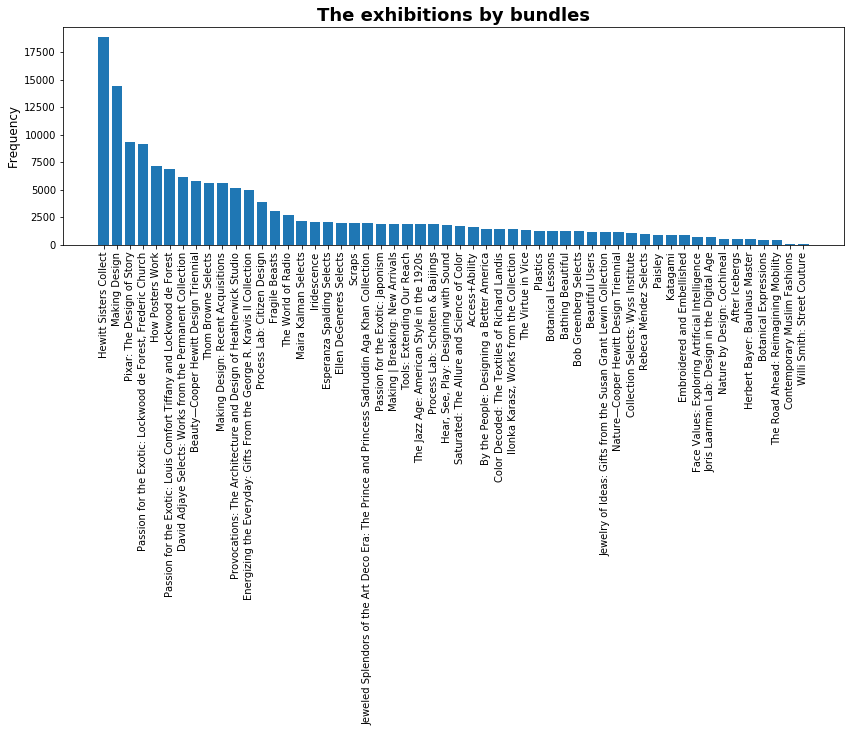

In [10]:
fig, ax = plt.subplots(figsize = (14,4))
ax.bar(to_1D(sbBundles['exhibition info']).value_counts().index,
        to_1D(sbBundles['exhibition info']).value_counts().values)
plt.xticks(rotation=90)
ax.set_ylabel("Frequency", size = 12)
ax.set_title("Exhibition Title", size = 14)
plt.title('The exhibitions by bundles', fontdict={'fontweight': 'bold', 'fontsize':18})
# plt.savefig('exhibition_SBbundle.png', dpi=300)
#we can see here the exhibitions that encourage the most bundles. 